# Проект удержание клиентов

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных, разрешая проблему оттока клиентов.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. 

Цель — провести анализ и подготовить план действий по удержанию клиентов.

Задачи:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1. выделить целевые группы клиентов;
    2. предложить меры по снижению оттока;
    3. определить другие особенности взаимодействия с клиентами.

## Содержание
[Шаг 1. Загрузка данных](#step0)

[Шаг 2. Исследовательский анализ данных (EDA)](#step1)

[Шаг 3. Бинарная модель классификации клиентов для прогнозирования оттока клиентов](#step2)

[Шаг 4. Кластеризация клиентов](#step3)

[Шаг 5. Выводы и рекомендации по работе с клиентами](#step4)

## Шаг 1. Загрузка данных

<a id="step0"></a> 

Файл содержит данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

1. Данные клиента за предыдущий до проверки факта оттока месяц:

- `'gender'` — пол;

- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр;

- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

- `'Promo_friends'` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

- `'Phone'` — наличие контактного телефона;

- `'Age'` — возраст;

- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах).


2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах);

- `'Group_visits'` — факт посещения групповых занятий;

- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента;

- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц;

- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

- `'Churn'` — факт оттока в текущем месяце.


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import itertools
import warnings
warnings.filterwarnings("ignore")

# Загрузка данных
try: 
    gym_churn = pd.read_csv('gym_churn.csv') # данные о заведениях общественного питания Москвы
except: 
    gym_churn = pd.read_csv('/datasets/gym_churn.csv')
    
pd.set_option('display.max_columns', None)

## Шаг 2. Исследовательский анализ данных (EDA)
<a id="step1"></a> 

In [2]:
gym_churn.columns = gym_churn.columns.str.lower()

In [3]:
gym_churn.info()
display(gym_churn.describe().T)
print('Количество дубликатов:', gym_churn.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Количество дубликатов: 0


В датасете 4000 строк, пропусков и дубликатов нет.

**Вывод**
- Распределение по полу примерно одинаковое
- 84,5% клиентов проживают по близости с фитнес-центром
- Около половины клиентов - сотрудники компаний-партнеров
- Примерно 30% клиентов пришли по акции "Приведи друга"
- Свой телефон оставили 90% клиентов
- На групповые тренировки хоть раз сходили 41% посетителей фитнес центра
- Средний возраст посетителей - 29 лет, возраст клиентов - 18-41 год
- От сопутствующих услуг (кафе, спортовары, косметический и массажный салон) фитнес центр получает в среднем 146.9 с клиента (очень большое отклонение, есть те, кто не пользуется доп услугами, а есть и такие, которые тратят больше)
- Средняя продолжительность жизни клиента (время, в течение которого клиент пользуется услугами центра) составляет 3,7 месяца
- В среднем клиент ходит 1,87 раз в неделю за все время действия абонемента, за последний месяц - 1,76 раз в неделю, клиенты посещают спорт зал 1-6 раз в неделю
- Доля оттока клиентов за все время составила 26,5%
- У переменных довольно разные по величине стандартные отклонения. Возможно, придется стандартизировать данные

Посмотрим на на средние значения признаков в двух группах — тех, кто ушел в отток (1) и тех, кто остался (0):

In [4]:
gym_churn.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


**Вывод**

Сформируем портрет "возвращающегося" клиента: он пришел в фитнес клуб как сотрудник компаний-партнеров или по акции "приведи друга"; занимаются в среднем дольше и чаще, чем те, кто ушел (по времени 6 месяцев vs 2 месяца и по частоте посещений в неделю 2 раза vs 1 раз), при этом они заключают более длительные договоры (количество оставшихся месяцев по контракту в средем 5.28 (vs 1.66 у ушедших) и средняя продолжительность пользования услугами 4.7 месяцев (vs 0.99). 

Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

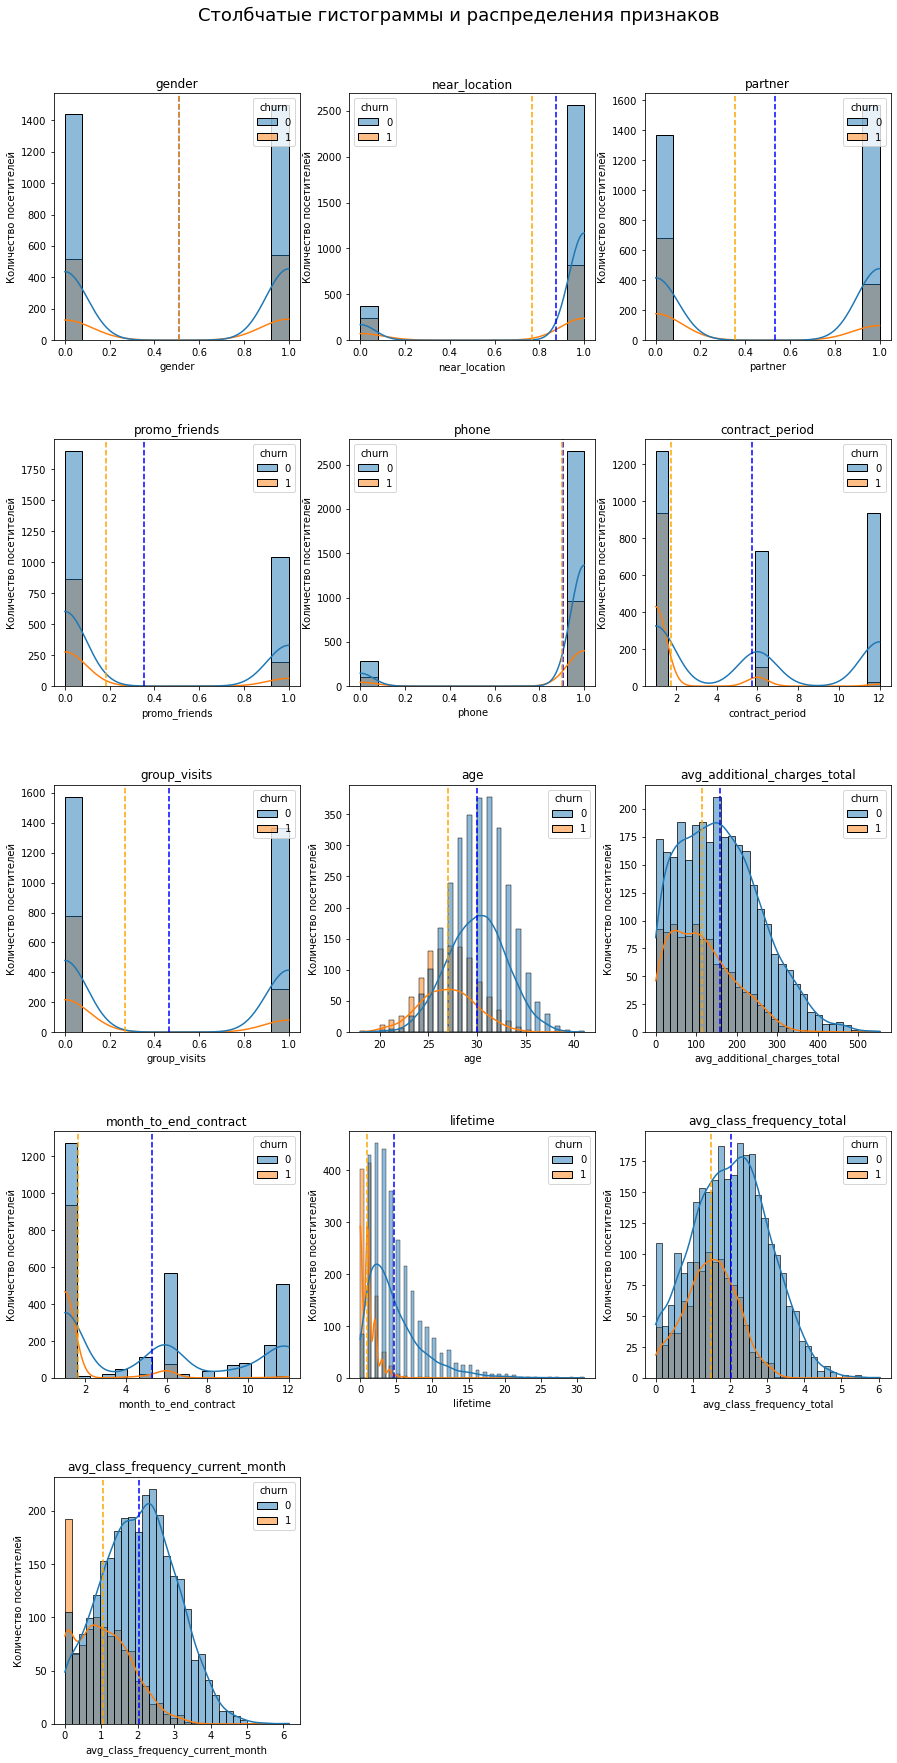

In [5]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Столбчатые гистограммы и распределения признаков", fontsize=18, y=0.92)
temp = gym_churn.drop('churn', axis=1).columns

for n, col in enumerate(gym_churn.drop('churn', axis=1).columns):
    ax = plt.subplot(5, 3, n + 1)

    sns.histplot(data=gym_churn, x=col, hue='churn', kde=True).plot(ax=ax)
    plt.axvline(gym_churn.query('churn == 0')[col].mean(), linestyle = '--', color = 'blue', label = 'mean 0')
    plt.axvline(gym_churn.query('churn == 1')[col].mean(), linestyle = '--', color = 'orange', label = 'mean 1')
    
    ax.set_title(col)
    ax.get_legend()
    ax.set_ylabel("Количество посетителей")

**Вывод**
- Гистограммы показывают, что чаще остаются клиенты, которые:
    - живут или работают неподалеку от центра
    - пришли по акции "приведи друга" 
    - посещаюют групповые занятия
    - за последний месяц ходили в среднем 2 раза в неделю
    
- От пола клиента отток не зависит

- Чаще уходят клиенты, подписавшие договор на 1 месяц. Те, кто подписал договор на 6 месяцев или год, дольше пользуются услугами фитнес центра.

- Гистограммы показывают, что чаще уходят:
    - молодые люди (от 20 до 26 лет)
    - время с момента первого их обращения в фитнес-центр составляет 1-2 месяца
    - те, кто приобрел абонемент на 1 месяц и кто в последний месяц занимался 1 раз в неделю
    
- Суммарная выручка от других услуг фитнес-центра на долю ушедших меньше относительно доли постоянных клиентов 

Построим матрицу корреляций

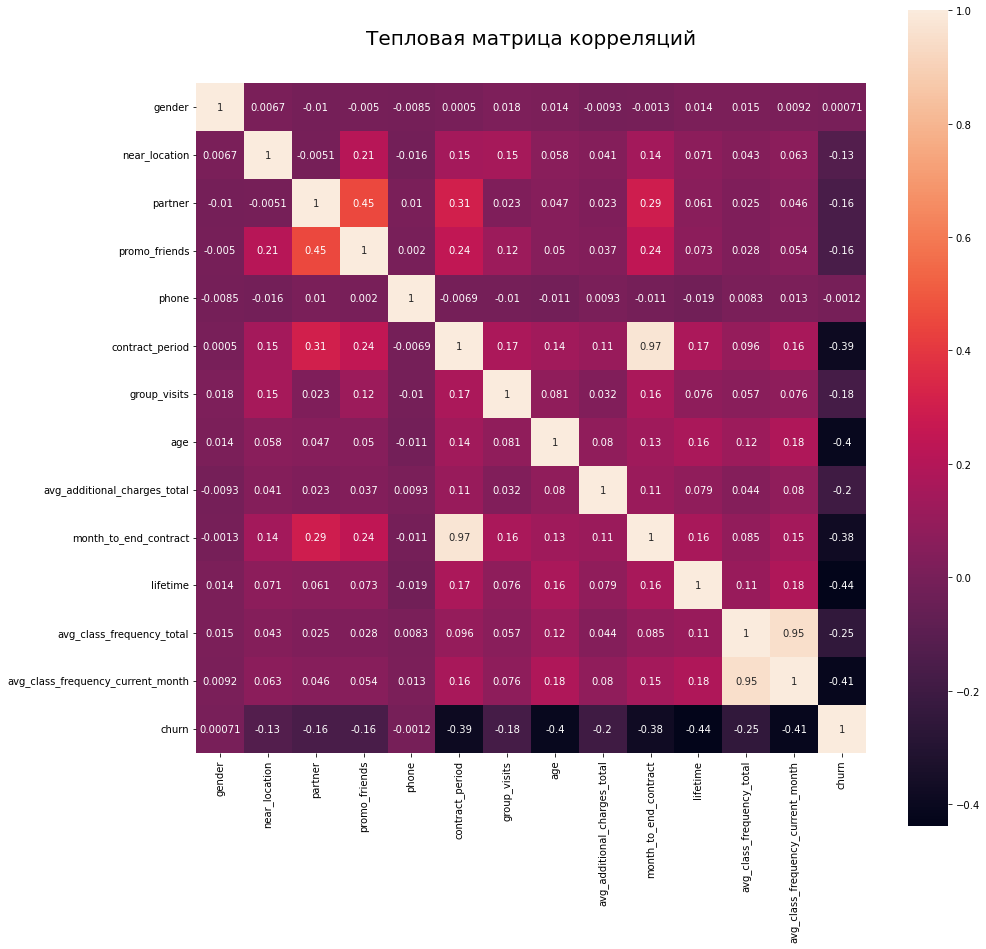

In [6]:
plt.figure(figsize=(15,15))
plt.title('Тепловая матрица корреляций', fontsize=20, y=1.05)
plt.xlabel('Признаки')
plt.ylabel('Признаки')
sns.heatmap(gym_churn.corr(), square=True, annot=True)
plt.show()

**Вывод** 
- По матрице можем заметить сильную корреляцию признаков avg_class_frequency_current_month и avg_class_frequency_total; month_to_end_contract и current_period - из-за этих показателей может возникнуть мультиколлинеарность и проблемы с линейной регрессией: нерепрезентативные веса и переобученная под эти признаки модель. Будем использовать L1 регуляризацию для построения модели линейной регрессии.

## Шаг 3. Бинарная модель классификации клиентов для прогнозирования оттока клиентов
<a id="step2"></a> 

Целевой признак модели - факт оттока в следующем месяце.

Разделим датафрейм на целевую переменную и обучающие признаки, затем разделим выборку на тренировочную и тестовую (валидационную) выборки.

In [7]:
# Разделение датафрейма на целевую переменную и обучающие признаки
y = gym_churn['churn']
X = gym_churn.drop(['churn'], axis = 1)

# Разделение выборки на тренировочную и тестовую (валидационную) выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [8]:
# стандартизируем данные
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [9]:
# Инициализация модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# Инициализация модели случайного леса
rf_model=RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train_st,y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

In [10]:
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.3f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.3f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.3f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.3f}'.format(roc_auc_score(y_true, y_proba)))

In [11]:
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)
print()
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:',
)

Метрики для модели логистической регрессии:
	Accuracy: 0.922
	Precision: 0.854
	Recall: 0.828
	F1: 0.841
	ROC_AUC: 0.971

Метрики для модели случайного леса:
	Accuracy: 0.915
	Precision: 0.839
	Recall: 0.813
	F1: 0.826
	ROC_AUC: 0.968


**Вывод**

Модель логистической регрессии показала лучшие результаты: доля правильных ответов (Accuracy) составила 0,922 (vs 0,915), доля прогнозов относительно целевого класса (Precision) составила 0,854 (vs 0,839) и доля реальных классов, которую смогла обнаружить модель (Recall), составила 0.828 (vs 0.813). Оценивая качество классификатора, посмотрим на метрику ROC_AUC: у модели логистической регрессии значение ближе к 1, а значит, модель делит на классы лучше. 

## Шаг 4. Кластеризация клиентов
<a id="step3"></a> 

Цель кластеризации - сегментация клиентов. Чтобы понять, сколько сегментов пользователей можно выделить, построим матрицу расстояний и нарисуем дендрограмму. 

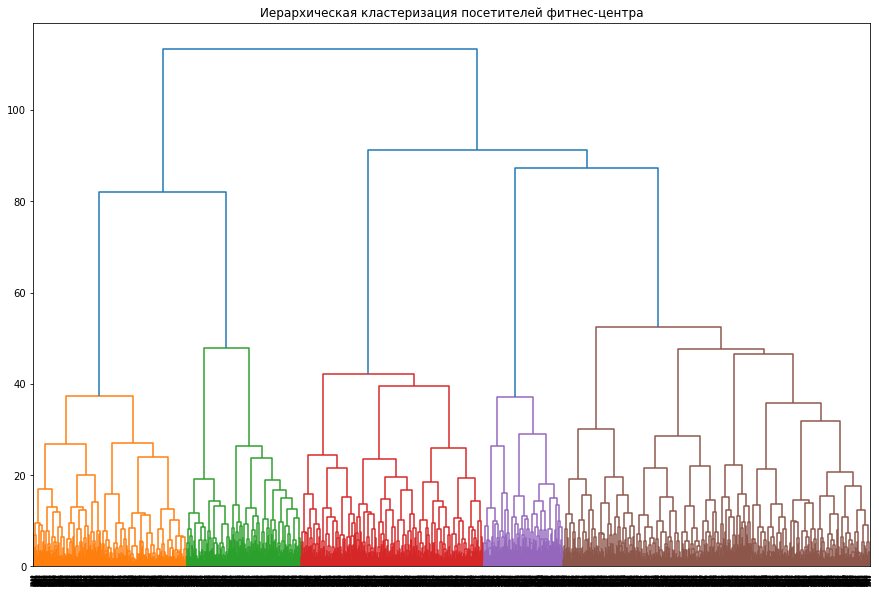

In [12]:
# Стандартизируем данные 
X_sc = scaler.fit_transform(gym_churn)

# Построение матрицы
linked = linkage(X_sc, method='ward')
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация посетителей фитнес-центра')
plt.show()

Будем выделять 5 классов.

In [13]:
# определим функцию отрисовки графиков попарных признаков для кластеров
def show_clusters_on_plot(df, x_name, y_name, cluster_name):
    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

In [14]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
gym_churn['cluster'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
clusters = gym_churn.groupby('cluster').agg('mean')
clusters.T
    

cluster,0,1,2,3,4
gender,0.503676,0.492829,0.507917,0.521186,0.518895
near_location,0.000000,0.936115,1.000000,0.996610,0.968023
partner,0.459559,0.764016,0.323995,0.282203,0.744186
promo_friends,0.075368,0.534550,0.213155,0.208475,0.526163
phone,0.917279,0.919166,0.903776,0.904237,0.873547
contract_period,2.069853,10.447197,1.546894,1.882203,8.859012
group_visits,0.211397,0.516297,0.287454,0.452542,0.534884
age,28.522059,29.962190,26.926918,30.237288,29.728198
avg_additional_charges_total,132.741216,161.853561,113.173051,157.988625,162.907495
month_to_end_contract,1.950368,9.477184,1.500609,1.794915,8.155523


По средним значениям можно сделать вывод, что чаще всего в отток попадает 2 кластер (96% из него уходят), при этом у него наименьший Lifetime, договор обычно на месяц и меньше всего в среднем посещений за последний месяц. И при этом все представители этого кластера живут/работают рядом.


По доле оттока: наиболее склонны к оттоку кластер 2 (96% уходят) и 0 (45% уходят), наименее - 3 кластер (отток 0,3%), 1 кластер (0,7%) и 4 кластер (2,5%).

In [15]:
palette = sns.color_palette("pastel", n_colors=5)

In [16]:
gym_churn.groupby('cluster')['age'].describe().T

cluster,0,1,2,3,4
count,544.000000,767.000000,821.000000,1180.000000,688.000000
mean,28.522059,29.962190,26.926918,30.237288,29.728198
std,3.210748,3.146946,2.844682,2.977376,2.902635
min,18.000000,20.000000,18.000000,21.000000,22.000000
25%,26.000000,28.000000,25.000000,28.000000,28.000000
50%,29.000000,30.000000,27.000000,30.000000,30.000000
75%,31.000000,32.000000,29.000000,32.000000,32.000000
max,37.000000,39.000000,38.000000,41.000000,38.000000


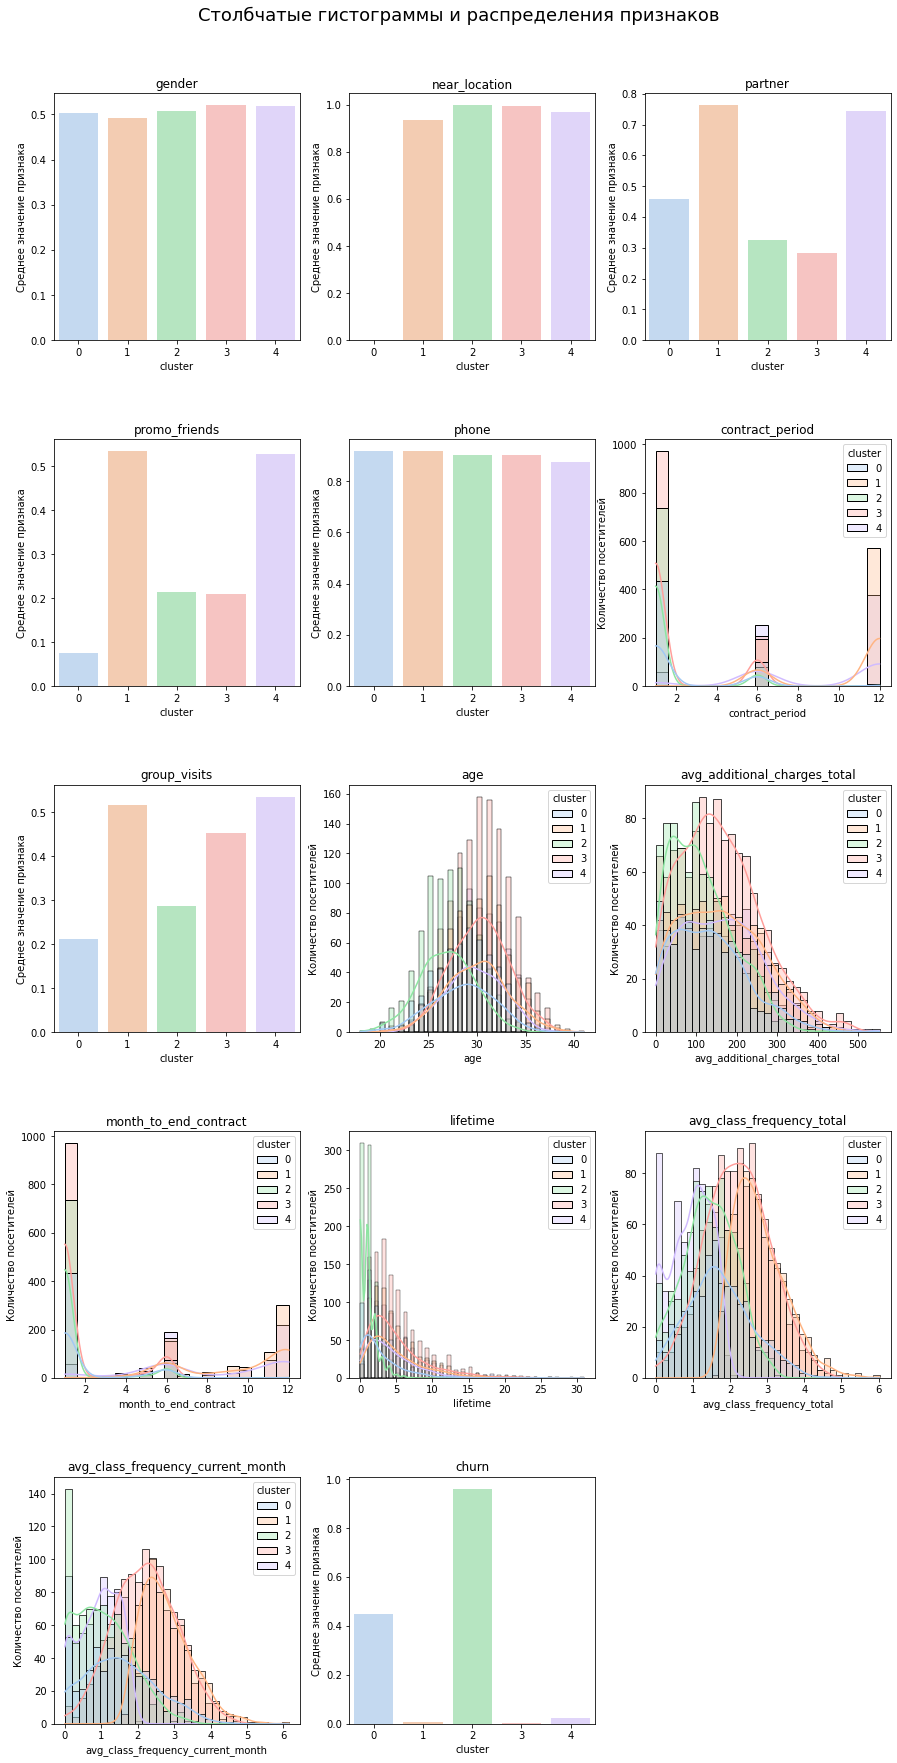

In [17]:
plt.figure(figsize=(15, 30))
plt.subplots_adjust(hspace=0.4)
plt.suptitle("Столбчатые гистограммы и распределения признаков", fontsize=18, y=0.92)
temp = gym_churn.drop('cluster', axis=1).columns

for n, col in enumerate(gym_churn.drop('cluster', axis=1).columns):
    ax = plt.subplot(5, 3, n + 1)
    if col in ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']:
        sns.barplot(data=gym_churn.groupby('cluster').agg('mean').reset_index(), x='cluster', y=col, alpha=0.7, palette = palette)
        ax.set_ylabel("Среднее значение признака")
    else:
        sns.histplot(data=gym_churn, x=col, hue='cluster', kde=True, alpha=0.3, palette = palette ).plot(ax=ax)
        ax.set_ylabel("Количество посетителей")

    ax.set_title(col)
    ax.get_legend()
    

**Вывод** 

Во всер кластерах в равных долях представлены и женщины, и мужчины; номера телефонов также клиенты предоставляют примерно в одинаковых долях в разных кластерах. 
Стоит обратить внимание на 0 и 2 кластер - они характеризуются высоким уровнем оттока. 

Можно сформировать портреты представителей кластеров:

*0 кластер*
- В основном приобретают абонементы на 1 месяц (реже на 6 месяцев), занимаются в основном менее, чем 5 месяцев
- Реже всех остальных занимаются в зале и ходят на групповые тренировки (1-3 раза в неделю, за последний месяц ходили 0-2 раза в неделю)
- Все посетители НЕ живут/работают рядом с фитнес центром
- Высокий уровень оттока
- Возраст: 28-31 год

*1 кластер и 4 кластер* 
- Чаще остальных приходят по акции "приведи друга" или являются сотрудниками партнерских компаний. 
- Характеризуются очень низким оттоком 
- Чаще остальных заключают длительные договора 
- Чаще ходят на групповые тренировки
- обладают примерно одинаковым lifetime
- примерно одинаковый возраст (1: 20-39 и 4: 22-37) и прибыль, которую они приносят доп покупками
- отличаются тем, что представители 1 кластера чаще ходят в спортзал, чем представители 4 кластера

*2 кластер*
- Большинство в возрасте 23-28 лет
- Заключают договор на 1 месяц или на 6 месяцев
- Совместно с 3 кластером приносят больше всего средней прибыли
- Обладают коротким сроком жизни клиента (до 5 месяцев)
- характеризуются самым высоким уровнем оттока
- Около 20% пришли по акции приведи друга и 30% - от компаний партнеров
- Обычно ходят на тренировки 1-2 раза в неделю, за последний месяц могли вообще не ходить 

*3 кластер*
- Приносят больше всего дополнительной прибыли
- Чаще остальных заключают договор на месяц/6 месяцев
- Большинству 28-32 года
- Чаще остальных ходят в фитнес клуб: обычно 2-3 раза в неделю, за последний месяц в среднем были 1-3 раза в неделю
- чаще 2 и 0 кластера посещают групповые тренировки (но реже, чем 1 и 4)
- Чуть меньше 30% пришли от компаний-партнеров и около 20% - по акции приведи друга
- Дольше остальных пользуются услугами фитнес центра

## Шаг 5. Выводы и рекомендации по работе с клиентами
<a id="step4"></a> 

Во многом маркетинговые стратегии исходят из потребностей конечного потребителя. Изучив данные, конечно, сложно сказать, что движет каждого представителя кластера ходить в спортивный зал, но можно выявить характерные черты, по которым сформировались группы. 

*Рекомендации*

Выделим 1 кластер: долгосрочные контракты, стабильные посещения, высокий Lifetime, высокие дополнительные расходы в фитнес центре. Пришли от компаний-партнеров. В долгосрочном периоде они могут принести прибыль. И отток менее 1%. Для такой категории следует использовать стратегию удержания: за счет них в долгосрочном периоде будет формироваться прибыль компании. 

Стоит обратить внимание и на 4 кластер: долгосрочные договоры, высокий Lifetime (4.41) и высокие доп траты, но 2,5% уходят - остается вопрос почему (74% пришли по акции партнера, 52% - от друзей). Возможно, стоит предложить скидку на продление абонемента, посмотреть на качество сервиса.

Думаю, чтобы удержать 1 и 4 кластер, по окончании их договоров стоит предложить продление заранее. Возможно, также стоит провести дополнительные мероприятия (например, марафон), на котором клиент также  сможет привести еще друзей, тем самым повышая лояльность.

Хочу также выделить 3 кластер как перспективный: низкий отток, большинство пришли сами, почти 5 месяцев средний лайфтайм, в спортзал чаще остальных ходят. Но они подписывают недолгосрочные контракты: стоит рассмотреть систему скидок на оплату сразу годового/шестимесячного абонемента. 

Нулевой кластер: спортзал для них находится далеко и при этом более половины выбрали сами этот фитнес клуб. Лайфтайм менее 3 месяцев, в спортзал ходят в среднем 1,7 раза в неделю. Неудивительно что и отток 45%. А те, кто остаются, скорее всего, приходят от партнеров. Возможно для таких клиентов стоит разработать программу сохранения/заморозок тренировок или предложить онлайн-тренировки. 

Особое внимание следует уделить второму кластеру, так как именно он характеризуется большим процентом оттока. Думаю, в этом случае следует провести опрос, почему клиенты уходят от компании, чего не хватает в фитнес центра. Скорее всего, вернуть клиентов не получится, но сформируется лояльность клиента к бренду и, возможно, недочеты, выявленные в интервью, покроют потребности будущих клиентов. 